In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

# Define the same model class in your new notebook
class HierarchicalMultiTaskModel(nn.Module):
    def __init__(self, base_model, hidden_dim=768, num_groups=17, num_targets=4, num_directness=3, sentiment_size=8):
        super().__init__()
        self.encoder = base_model

        self.hate_head = nn.Linear(hidden_dim, 1)
        self.directness_head = nn.Linear(hidden_dim + 1, 3)
        self.target_head = nn.Linear(hidden_dim + 3, 7)
        self.group_head = nn.Linear(hidden_dim + 7, 17)
        self.sentiment_head = nn.Linear(hidden_dim, 8)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token

        hate_logits = self.hate_head(pooled_output)
        directness_logits = self.directness_head(torch.cat([pooled_output, torch.sigmoid(hate_logits)], dim=1))
        target_logits = self.target_head(torch.cat([pooled_output, torch.softmax(directness_logits, dim=1)], dim=1))
        group_logits = self.group_head(torch.cat([pooled_output, torch.softmax(target_logits, dim=1)], dim=1))
        sentiment_logits = self.sentiment_head(pooled_output)

        return {
            'hate': hate_logits.squeeze(-1),
            'directness': directness_logits,
            'target': target_logits,
            'group': group_logits,
            'sentiments': sentiment_logits
        }

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/DS266/Project/Modeling/my_model/saved_tokenizer/")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = AutoModel.from_pretrained("xlm-roberta-base")
model = HierarchicalMultiTaskModel(base_model).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/DS266/Project/Modeling/my_model/hierarchical_multitask_model.pt"))
model.eval()

print("Model and tokenizer loaded successfully.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Model and tokenizer loaded successfully.


In [4]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_test.csv')
display(test_df.head())

,text_cleaned,language,directness_label,target_label,group_label,hatespeech,hatespeech.1,directness_label.1,target_label.1,group_label.1,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock,language_encoded
0,imagine yoongi working tongue technology hands...,english,1,4,13,1,1,1,4,13,1,0,1,0,1,0,1,1,0
1,fuck retard,english,1,0,15,1,1,1,0,15,0,1,0,0,1,0,0,0,0
2,اللهم أمين @ كفرنجه,arabic,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,2
3,يع كيف يشترون كذا 😷,arabic,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,2
4,Réunion entre les membres de la commission fem...,french,2,2,12,0,0,2,2,12,0,0,0,0,0,1,0,0,1


In [5]:
from torch.utils.data import Dataset, DataLoader

class TestDataset(Dataset):
    def __init__(self, tokenizer, texts, max_len=128):
        self.tokenizer = tokenizer
        self.texts = texts
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

test_dataset = TestDataset(tokenizer, test_df['text_cleaned'].tolist())
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
import json

json_string = """
{
    "directness": {
        "0": "direct",
        "1": "indirect",
        "2": "normal"
    },
    "target": {
        "0": "disability",
        "1": "gender",
        "2": "normal",
        "3": "origin",
        "4": "other",
        "5": "religion",
        "6": "sexual_orientation"
    },
    "group": {
        "0": "african_descent",
        "1": "arabs",
        "2": "asians",
        "3": "christian",
        "4": "gay",
        "5": "hispanics",
        "6": "immigrants",
        "7": "indian/hindu",
        "8": "individual",
        "9": "jews",
        "10": "left_wing_people",
        "11": "muslims",
        "12": "normal",
        "13": "other",
        "14": "refugees",
        "15": "special_needs",
        "16": "women"
    }
}
"""

label_maps = json.loads(json_string)

directness_map = label_maps['directness']
target_map = label_maps['target']
group_map = label_maps['group']


# Define label categories and their corresponding lists of label names in the desired order
sentiment_label_names = [
    "sentiment_anger",
    "sentiment_confusion",
    "sentiment_disgust",
    "sentiment_fear",
    "sentiment_indifference",
    "sentiment_normal",
    "sentiment_sadness",
    "sentiment_shock"
]

# Assuming these lists are defined elsewhere or can be derived from the data/map
# If not defined, you might need to define them based on your data or the maps
directness_label_names = list(directness_map.values())
target_label_names = list(target_map.values())
group_label_names = list(group_map.values())

# Define label categories and their corresponding lists of label names in the desired order
label_categories = {
    'hatespeech': ['hatespeech'],
    'directness': directness_label_names,
    'target': target_label_names,
    'group': group_label_names,
    'sentiment': sentiment_label_names,
}

# Define the mapping for multiclass labels to their descriptive names
multiclass_label_maps = {
    'directness': directness_map,
    'target': target_map,
    'group': group_map
}

print("Directness Map:")
print(directness_map)
print("\nTarget Map:")
print(target_map)
print("\nGroup Map:")
print(group_map)

Directness Map:
{'0': 'direct', '1': 'indirect', '2': 'normal'}

Target Map:
{'0': 'disability', '1': 'gender', '2': 'normal', '3': 'origin', '4': 'other', '5': 'religion', '6': 'sexual_orientation'}

Group Map:
{'0': 'african_descent', '1': 'arabs', '2': 'asians', '3': 'christian', '4': 'gay', '5': 'hispanics', '6': 'immigrants', '7': 'indian/hindu', '8': 'individual', '9': 'jews', '10': 'left_wing_people', '11': 'muslims', '12': 'normal', '13': 'other', '14': 'refugees', '15': 'special_needs', '16': 'women'}


In [7]:
import numpy as np

# store predictions
all_preds = {
    'hate': [],
    'directness': [],
    'target': [],
    'group': [],
    'sentiments': []
}

# no gradients needed
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)

        # Process predictions
        all_preds['hate'].extend(torch.sigmoid(outputs['hate']).cpu().numpy())
        all_preds['directness'].extend(torch.softmax(outputs['directness'], dim=1).cpu().numpy())
        all_preds['target'].extend(torch.softmax(outputs['target'], dim=1).cpu().numpy())
        all_preds['group'].extend(torch.softmax(outputs['group'], dim=1).cpu().numpy())
        all_preds['sentiments'].extend(torch.sigmoid(outputs['sentiments']).cpu().numpy())

# Convert predictions to a more usable format
for key in all_preds:
    all_preds[key] = np.array(all_preds[key])

# For classification tasks, you might want to get the predicted class index
predicted_directness = np.argmax(all_preds['directness'], axis=1)
predicted_target = np.argmax(all_preds['target'], axis=1)
predicted_group = np.argmax(all_preds['group'], axis=1)

# For hate speech and sentiments, you might want to apply a threshold
predicted_hate = (np.array(all_preds['hate']) > 0.5).astype(int)
predicted_sentiments = (np.array(all_preds['sentiments']) > 0.5).astype(int)

## Show Metrics

In [8]:
from sklearn.metrics import f1_score

sentiment_labels = ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']

# Hate Speech
hate_f1_micro = f1_score(test_df['hatespeech'], predicted_hate, average='micro')

# Directness
directness_f1_micro = f1_score(test_df['directness_label'], predicted_directness, average='micro')

# Target
target_f1_micro = f1_score(test_df['target_label'], predicted_target, average='micro')

# Group
group_f1_micro = f1_score(test_df['group_label'], predicted_group, average='micro')

# Sentiments
sentiment_f1_micro = f1_score(test_df[sentiment_labels], predicted_sentiments, average='micro')

# Overall
all_true_labels = np.concatenate([
    test_df['hatespeech'],
    test_df['directness_label'],
    test_df['target_label'],
    test_df['group_label'],
    test_df[sentiment_labels].values.flatten()
])

all_predicted_labels = np.concatenate([
    predicted_hate,
    predicted_directness,
    predicted_target,
    predicted_group,
    predicted_sentiments.flatten()
])

overall_f1_micro = f1_score(all_true_labels, all_predicted_labels, average='micro')


print("Micro F1 Scores:\n")

print(f"Hate Speech F1-Score (Micro): {hate_f1_micro:.4f}")
print(f"Directness F1-Score (Micro): {directness_f1_micro:.4f}")
print(f"Target F1-Score (Micro): {target_f1_micro:.4f}")
print(f"Group F1-Score (Micro): {group_f1_micro:.4f}")
print(f"Sentiment F1-Score (Micro): {sentiment_f1_micro:.4f}\n")
print(f"Overall Model F1-Score (Micro): {overall_f1_micro:.4f}")

Micro F1 Scores:

Hate Speech F1-Score (Micro): 0.9551
Directness F1-Score (Micro): 0.8475
Target F1-Score (Micro): 0.8172
Group F1-Score (Micro): 0.7490
Sentiment F1-Score (Micro): 0.6476

Overall Model F1-Score (Micro): 0.8545


In [9]:
# --- Micro F1 Scores per Language ---
print("\n--- Micro F1 Scores per Language ---")

languages = test_df['language'].unique()

for lang in languages:
    print(f"\n--- {lang.capitalize()} ---")

    lang_indices = test_df[test_df['language'] == lang].index

    test_df_lang = test_df.loc[lang_indices]
    predicted_hate_lang = predicted_hate[lang_indices]
    predicted_directness_lang = predicted_directness[lang_indices]
    predicted_target_lang = predicted_target[lang_indices]
    predicted_group_lang = predicted_group[lang_indices]
    predicted_sentiments_lang = predicted_sentiments[lang_indices]


    # Hate Speech F1 per language
    hate_f1_micro_lang = f1_score(test_df_lang['hatespeech'], predicted_hate_lang, average='micro', zero_division=0)
    print(f"Hate Speech F1-Score (Micro): {hate_f1_micro_lang:.4f}")

    # Directness F1 per language
    directness_f1_micro_lang = f1_score(test_df_lang['directness_label'], predicted_directness_lang, average='micro', zero_division=0)
    print(f"Directness F1-Score (Micro): {directness_f1_micro_lang:.4f}")

    # Target F1 per language
    target_f1_micro_lang = f1_score(test_df_lang['target_label'], predicted_target_lang, average='micro', zero_division=0)
    print(f"Target F1-Score (Micro): {target_f1_micro_lang:.4f}")

    # Group F1 per language
    group_f1_micro_lang = f1_score(test_df_lang['group_label'], predicted_group_lang, average='micro', zero_division=0)
    print(f"Group F1-Score (Micro): {group_f1_micro_lang:.4f}")

    # Sentiments F1 per language
    sentiment_f1_micro_lang = f1_score(test_df_lang[sentiment_labels], predicted_sentiments_lang, average='micro', zero_division=0)
    print(f"Sentiment F1-Score (Micro): {sentiment_f1_micro_lang:.4f}")

    # Overall F1 per language
    all_true_labels_lang = np.concatenate([
        test_df_lang['hatespeech'],
        test_df_lang['directness_label'],
        test_df_lang['target_label'],
        test_df_lang['group_label'],
        test_df_lang[sentiment_labels].values.flatten()
    ])

    all_predicted_labels_lang = np.concatenate([
        predicted_hate_lang,
        predicted_directness_lang,
        predicted_target_lang,
        predicted_group_lang,
        predicted_sentiments_lang.flatten()
    ])

    overall_f1_micro_lang = f1_score(all_true_labels_lang, all_predicted_labels_lang, average='micro', zero_division=0)
    print(f"Overall Model F1-Score (Micro): {overall_f1_micro_lang:.4f}")


--- Micro F1 Scores per Language ---

--- English ---
Hate Speech F1-Score (Micro): 0.9939
Directness F1-Score (Micro): 0.9397
Target F1-Score (Micro): 0.8732
Group F1-Score (Micro): 0.7610
Sentiment F1-Score (Micro): 0.6705
Overall Model F1-Score (Micro): 0.8468

--- Arabic ---
Hate Speech F1-Score (Micro): 0.9844
Directness F1-Score (Micro): 0.8141
Target F1-Score (Micro): 0.8261
Group F1-Score (Micro): 0.8633
Sentiment F1-Score (Micro): 0.7207
Overall Model F1-Score (Micro): 0.9126

--- French ---
Hate Speech F1-Score (Micro): 0.8396
Directness F1-Score (Micro): 0.6652
Target F1-Score (Micro): 0.6803
Group F1-Score (Micro): 0.6189
Sentiment F1-Score (Micro): 0.4446
Overall Model F1-Score (Micro): 0.8203


## Show Confusion Matrices

--- Overall Evaluation ---
Hate Speech Classification Report (Overall):
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2024
           1       0.93      0.98      0.95      1877

    accuracy                           0.96      3901
   macro avg       0.96      0.96      0.96      3901
weighted avg       0.96      0.96      0.96      3901


Confusion Matrix (Overall):


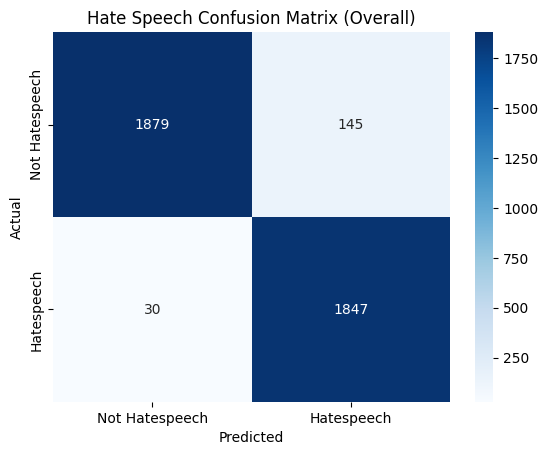


Directness Classification Report (Overall):
              precision    recall  f1-score   support

      direct       0.55      0.40      0.47       562
    indirect       0.77      0.91      0.83      1315
      normal       0.97      0.93      0.95      2024

    accuracy                           0.85      3901
   macro avg       0.76      0.75      0.75      3901
weighted avg       0.84      0.85      0.84      3901


Confusion Matrix (Overall):


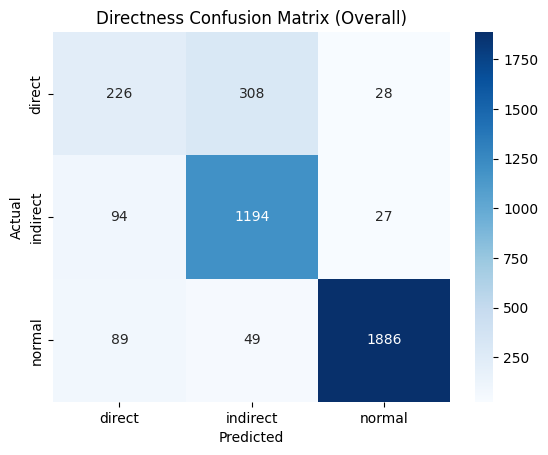


Target Classification Report (Overall):
                    precision    recall  f1-score   support

        disability       0.75      0.72      0.74       254
            gender       0.60      0.55      0.57       175
            normal       0.98      0.93      0.95      2024
            origin       0.78      0.75      0.76       840
             other       0.49      0.64      0.55       467
          religion       0.44      0.35      0.39        52
sexual_orientation       0.71      0.90      0.79        89

          accuracy                           0.82      3901
         macro avg       0.68      0.69      0.68      3901
      weighted avg       0.83      0.82      0.82      3901


Confusion Matrix (Overall):


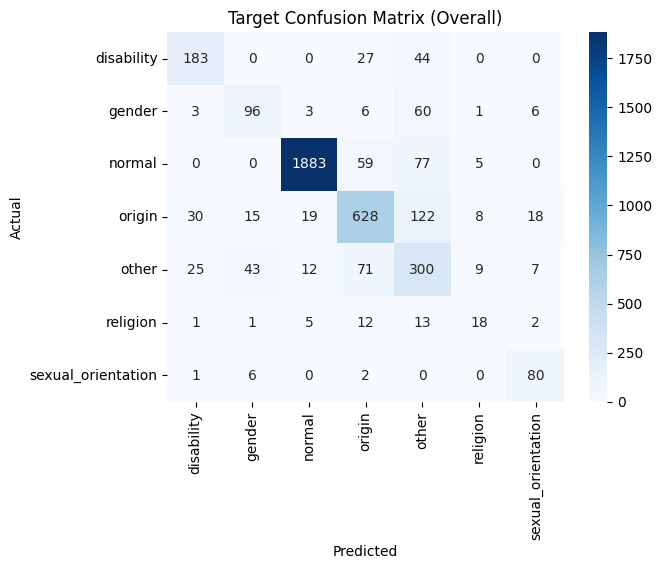


Group Classification Report (Overall):
                  precision    recall  f1-score   support

 african_descent       0.35      0.32      0.33        79
           arabs       0.42      0.77      0.55        35
          asians       0.22      0.52      0.31        27
       christian       0.00      0.00      0.00         3
             gay       0.48      0.37      0.42        30
       hispanics       0.17      0.04      0.07        24
      immigrants       0.40      0.42      0.41        43
    indian/hindu       0.00      0.00      0.00        56
      individual       0.40      0.43      0.42       286
            jews       0.50      0.29      0.37        17
left_wing_people       0.47      0.49      0.48        71
         muslims       0.39      0.18      0.25        39
          normal       0.97      0.94      0.95      2024
           other       0.51      0.59      0.55       578
        refugees       0.50      0.34      0.41        32
   special_needs       0.72    

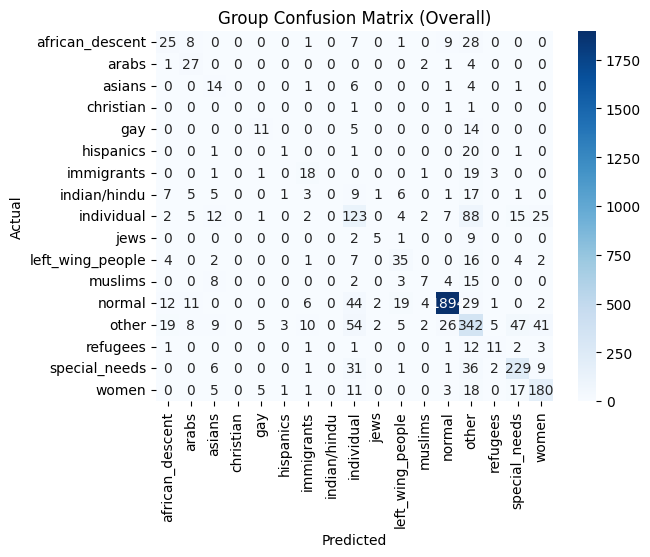


Sentiment Classification Report (Overall):

Classification Report for sentiment_anger (Overall):
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3230
           1       0.52      0.73      0.61       671

    accuracy                           0.84      3901
   macro avg       0.73      0.80      0.75      3901
weighted avg       0.87      0.84      0.85      3901



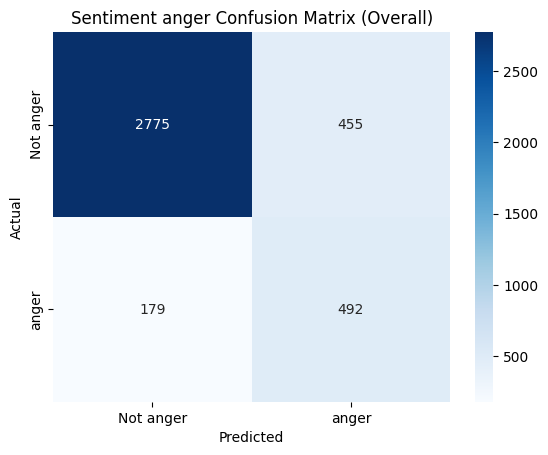


Classification Report for sentiment_confusion (Overall):
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3517
           1       1.00      0.00      0.01       384

    accuracy                           0.90      3901
   macro avg       0.95      0.50      0.48      3901
weighted avg       0.91      0.90      0.86      3901



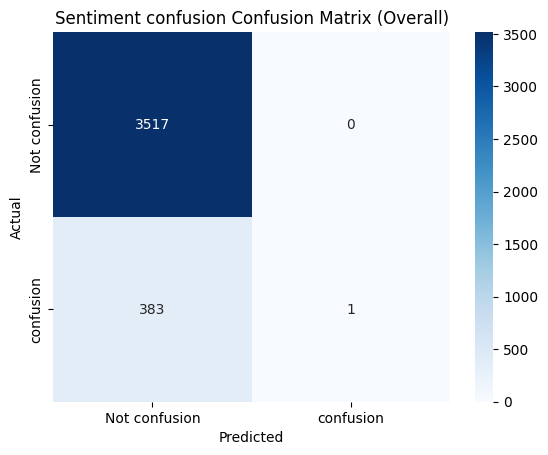


Classification Report for sentiment_disgust (Overall):
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3078
           1       0.61      0.80      0.69       823

    accuracy                           0.85      3901
   macro avg       0.78      0.83      0.80      3901
weighted avg       0.87      0.85      0.86      3901



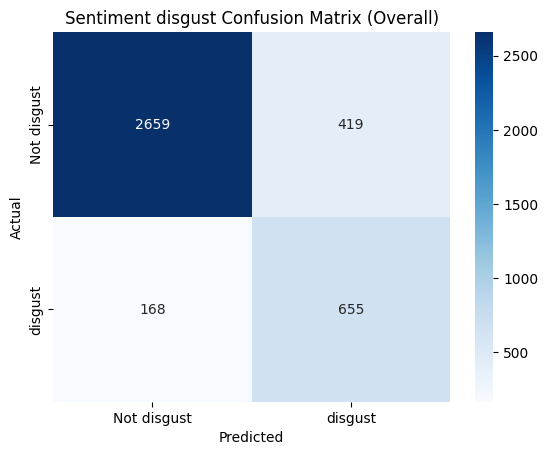


Classification Report for sentiment_fear (Overall):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3631
           1       0.00      0.00      0.00       270

    accuracy                           0.93      3901
   macro avg       0.47      0.50      0.48      3901
weighted avg       0.87      0.93      0.90      3901



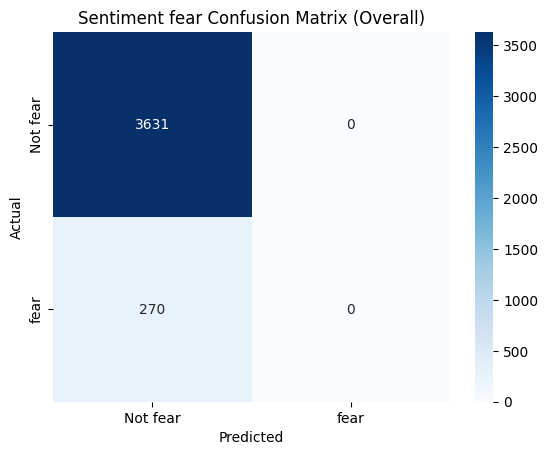


Classification Report for sentiment_indifference (Overall):
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      2944
           1       0.52      0.57      0.54       957

    accuracy                           0.76      3901
   macro avg       0.69      0.70      0.69      3901
weighted avg       0.77      0.76      0.77      3901



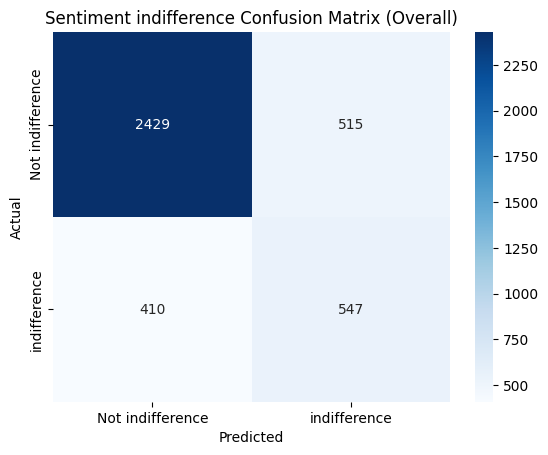


Classification Report for sentiment_normal (Overall):
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1877
           1       0.98      0.93      0.96      2024

    accuracy                           0.95      3901
   macro avg       0.96      0.96      0.95      3901
weighted avg       0.96      0.95      0.95      3901



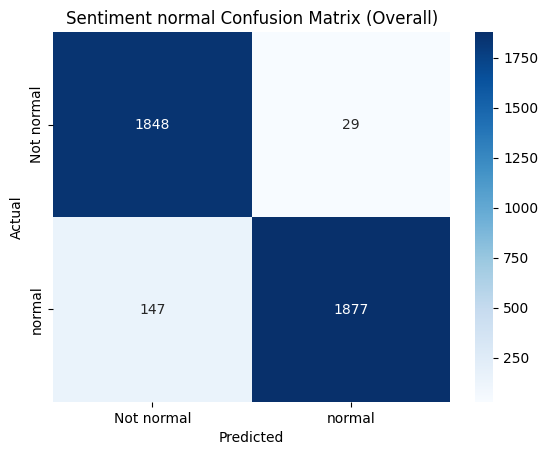


Classification Report for sentiment_sadness (Overall):
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3170
           1       0.52      0.58      0.55       731

    accuracy                           0.82      3901
   macro avg       0.71      0.73      0.72      3901
weighted avg       0.83      0.82      0.82      3901



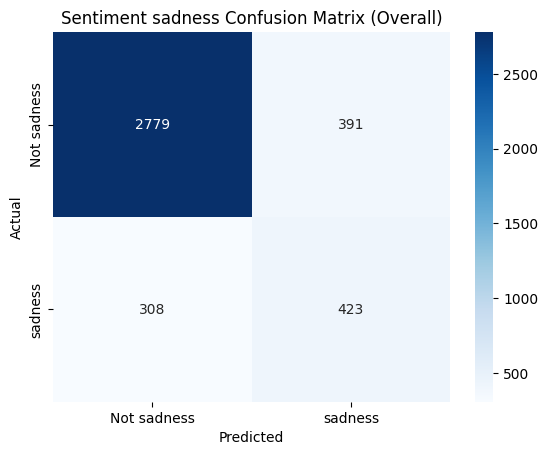


Classification Report for sentiment_shock (Overall):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      3228
           1       0.00      0.00      0.00       673

    accuracy                           0.83      3901
   macro avg       0.41      0.50      0.45      3901
weighted avg       0.68      0.83      0.75      3901



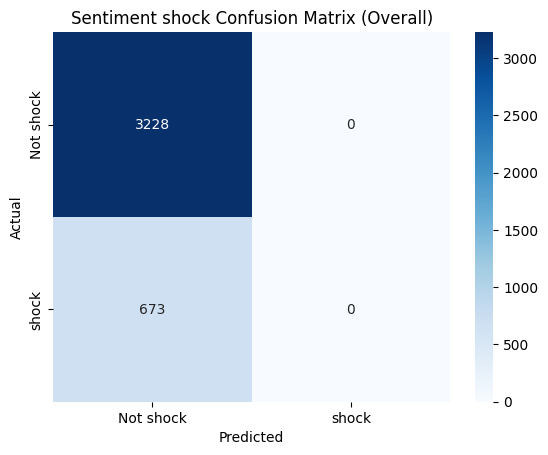

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# --- Overall Evaluation ---
print("--- Overall Evaluation ---")

# Hate Speech Evaluation (Overall)
print("Hate Speech Classification Report (Overall):")
print(classification_report(test_df['hatespeech'], predicted_hate, zero_division=0))
print("\nConfusion Matrix (Overall):")
cm = confusion_matrix(test_df['hatespeech'], predicted_hate)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hatespeech', 'Hatespeech'], yticklabels=['Not Hatespeech', 'Hatespeech'])
plt.title('Hate Speech Confusion Matrix (Overall)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Directness Evaluation (Overall)
print("\nDirectness Classification Report (Overall):")
print(classification_report(test_df['directness_label'], predicted_directness, target_names=directness_label_names, zero_division=0))
print("\nConfusion Matrix (Overall):")
cm = confusion_matrix(test_df['directness_label'], predicted_directness)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=directness_label_names, yticklabels=directness_label_names)
plt.title('Directness Confusion Matrix (Overall)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Target Evaluation (Overall)
print("\nTarget Classification Report (Overall):")
print(classification_report(test_df['target_label'], predicted_target, target_names=target_label_names, zero_division=0))
print("\nConfusion Matrix (Overall):")
cm = confusion_matrix(test_df['target_label'], predicted_target)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_label_names, yticklabels=target_label_names)
plt.title('Target Confusion Matrix (Overall)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xlabel('Predicted')
plt.show()

# Group Evaluation (Overall)
print("\nGroup Classification Report (Overall):")
print(classification_report(test_df['group_label'], predicted_group, target_names=group_label_names, zero_division=0))
print("\nConfusion Matrix (Overall):")
cm = confusion_matrix(test_df['group_label'], predicted_group)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=group_label_names, yticklabels=group_label_names)
plt.title('Group Confusion Matrix (Overall)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Sentiment Evaluation (Overall)
print("\nSentiment Classification Report (Overall):")
sentiment_labels = ['sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock']
for i, label in enumerate(sentiment_labels):
    print(f"\nClassification Report for {label} (Overall):")
    print(classification_report(test_df[label], predicted_sentiments[:, i], zero_division=0))
    cm = confusion_matrix(test_df[label], predicted_sentiments[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not ' + label.split('_')[1], label.split('_')[1]], yticklabels=['Not ' + label.split('_')[1], label.split('_')[1]])
    plt.title(f'{label.replace("_", " ").capitalize()} Confusion Matrix (Overall)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()



--- Evaluation per Language ---

--- English - Hate Speech Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1036
           1       0.99      1.00      0.99      1102

    accuracy                           0.99      2138
   macro avg       0.99      0.99      0.99      2138
weighted avg       0.99      0.99      0.99      2138


--- English - Directness Classification Report ---
              precision    recall  f1-score   support

      direct       0.00      0.00      0.00       115
    indirect       0.89      0.99      0.94       987
      normal       1.00      0.99      0.99      1036

    accuracy                           0.94      2138
   macro avg       0.63      0.66      0.64      2138
weighted avg       0.89      0.94      0.91      2138


--- English - Target Classification Report ---
                    precision    recall  f1-score   support

        disability       0.75      0.88      

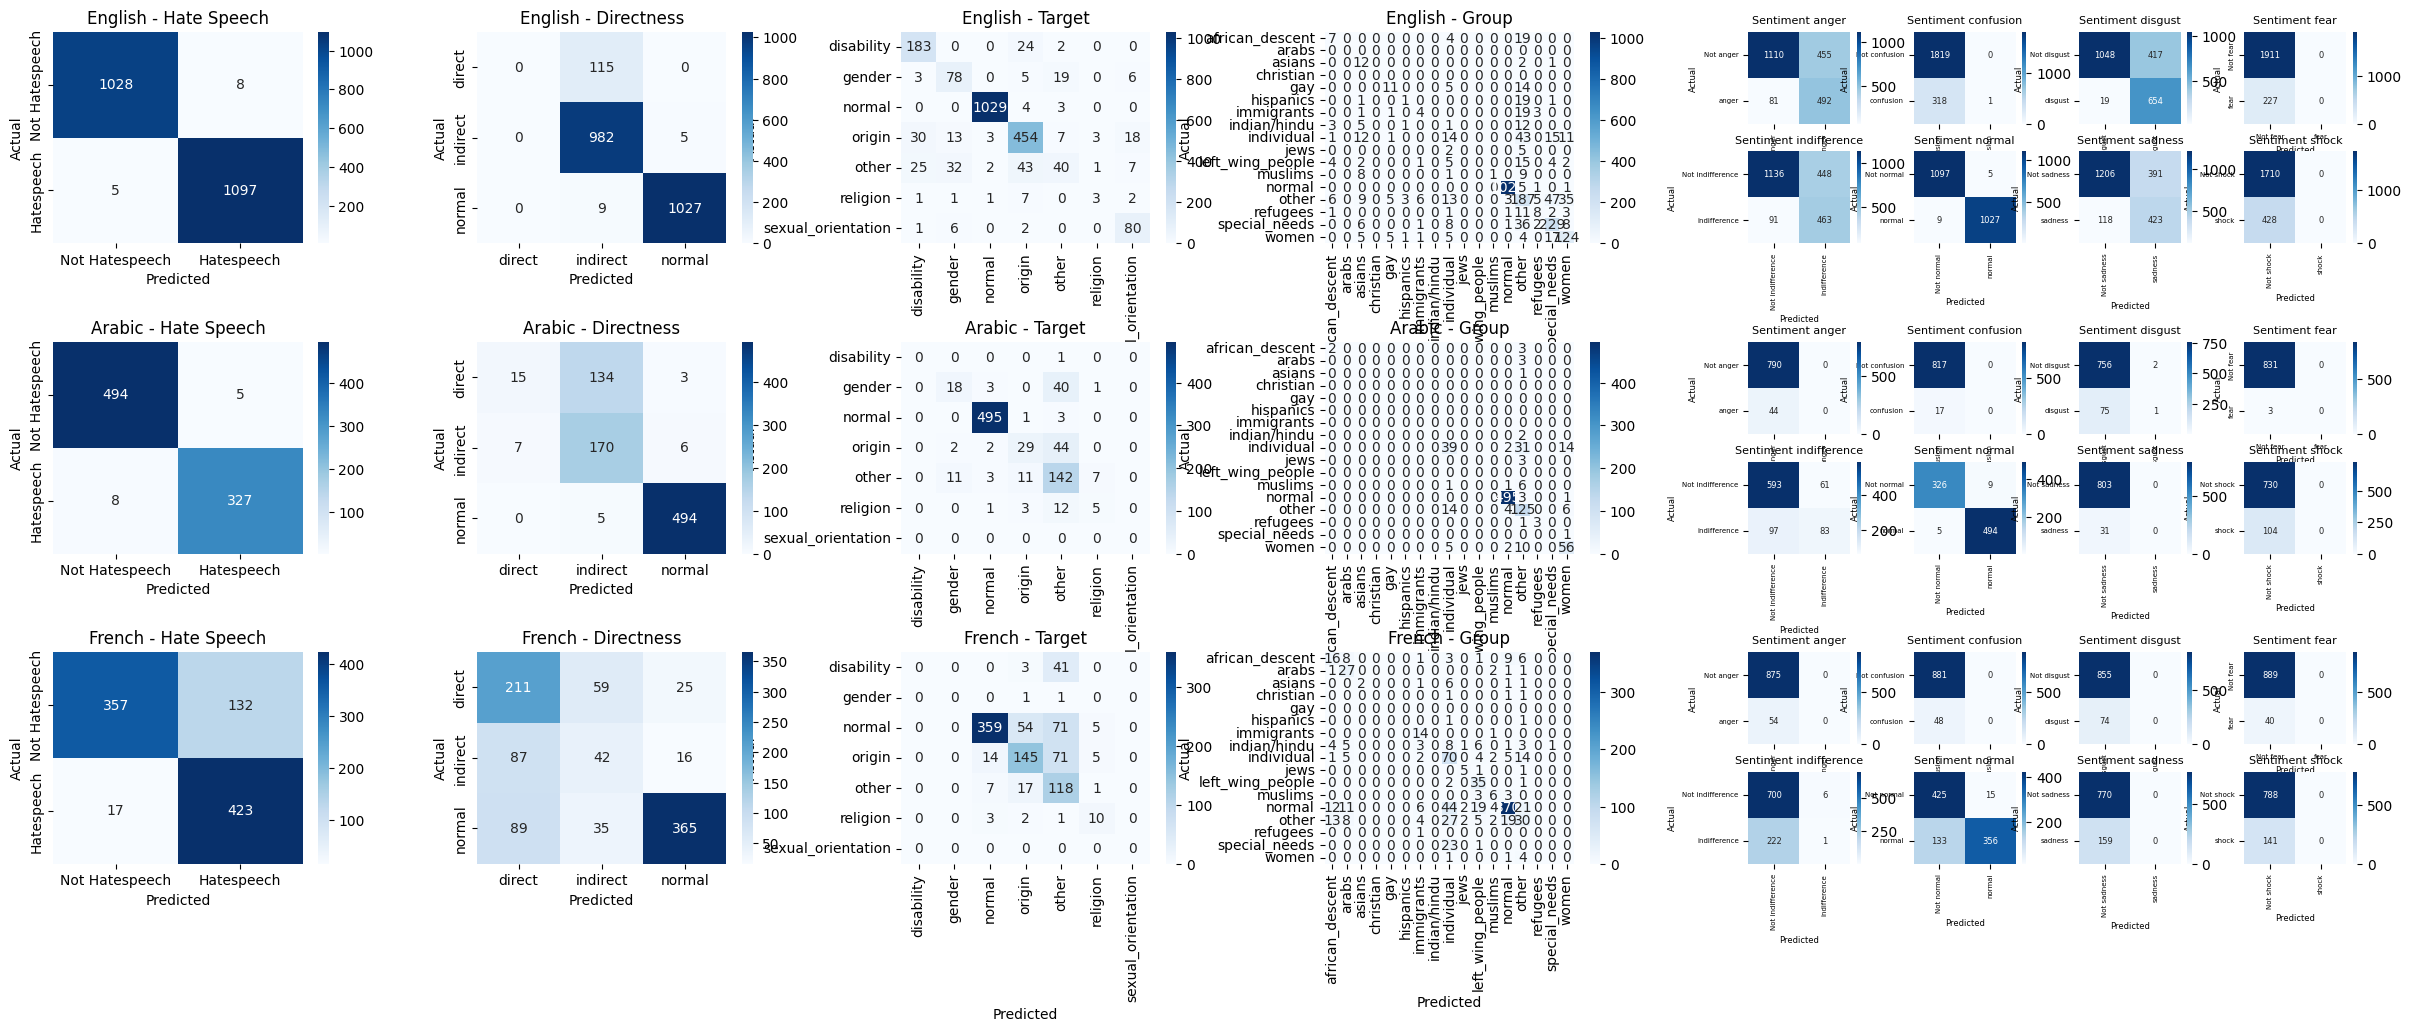

In [11]:
# --- Evaluation per Language ---
print("\n--- Evaluation per Language ---")

# Get unique languages
languages = test_df['language'].unique()
metrics = ['hatespeech', 'directness', 'target', 'group', 'sentiment'] # Keep sentiment as one column conceptually

# Create the main figure and subplots
# We need 3 rows for languages and 5 columns for metrics.
# The last column will be a gridspec for sentiment confusion matrices.
# Reduced figure height to make subplots more square
fig = plt.figure(figsize=(25, 10))
# Adjusted width ratios to make the first four columns larger
gs = fig.add_gridspec(nrows=len(languages), ncols=len(metrics), width_ratios=[2, 2, 2, 2, 4])

# Create axes directly using the gridspec
axes = [[fig.add_subplot(gs[i, j]) for j in range(len(metrics))] for i in range(len(languages))]
# Convert the list of lists of axes into a numpy array for easier indexing
axes = np.array(axes)


fig.tight_layout(pad=5.0) # Adjust padding

for i, lang in enumerate(languages):
    lang_indices = test_df[test_df['language'] == lang].index
    test_df_lang = test_df.loc[lang_indices]
    predicted_hate_lang = predicted_hate[lang_indices]
    predicted_directness_lang = predicted_directness[lang_indices]
    predicted_target_lang = predicted_target[lang_indices]
    predicted_group_lang = predicted_group[lang_indices]
    predicted_sentiments_lang = predicted_sentiments[lang_indices]

    # Hate Speech
    cm = confusion_matrix(test_df_lang['hatespeech'], predicted_hate_lang)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 0], xticklabels=['Not Hatespeech', 'Hatespeech'], yticklabels=['Not Hatespeech', 'Hatespeech'])
    axes[i, 0].set_title(f'{lang.capitalize()} - Hate Speech')
    axes[i, 0].set_ylabel('Actual')
    axes[i, 0].set_xlabel('Predicted')
    print(f"\n--- {lang.capitalize()} - Hate Speech Classification Report ---")
    print(classification_report(test_df_lang['hatespeech'], predicted_hate_lang, zero_division=0))


    # Directness
    cm = confusion_matrix(test_df_lang['directness_label'], predicted_directness_lang, labels=np.arange(len(directness_label_names)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 1], xticklabels=directness_label_names, yticklabels=directness_label_names)
    axes[i, 1].set_title(f'{lang.capitalize()} - Directness')
    axes[i, 1].set_ylabel('Actual')
    axes[i, 1].set_xlabel('Predicted')
    print(f"\n--- {lang.capitalize()} - Directness Classification Report ---")
    print(classification_report(test_df_lang['directness_label'], predicted_directness_lang, target_names=directness_label_names, labels=np.arange(len(directness_label_names)), zero_division=0))


    # Target
    cm = confusion_matrix(test_df_lang['target_label'], predicted_target_lang, labels=np.arange(len(target_label_names)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 2], xticklabels=target_label_names, yticklabels=target_label_names)
    axes[i, 2].set_title(f'{lang.capitalize()} - Target')
    axes[i, 2].set_ylabel('Actual')
    axes[i, 2].set_xlabel('Predicted')
    print(f"\n--- {lang.capitalize()} - Target Classification Report ---")
    print(classification_report(test_df_lang['target_label'], predicted_target_lang, target_names=target_label_names, labels=np.arange(len(target_label_names)), zero_division=0))


    # Group
    cm = confusion_matrix(test_df_lang['group_label'], predicted_group_lang, labels=np.arange(len(group_label_names)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 3], xticklabels=group_label_names, yticklabels=group_label_names)
    axes[i, 3].set_title(f'{lang.capitalize()} - Group')
    axes[i, 3].set_ylabel('Actual')
    axes[i, 3].set_xlabel('Predicted')
    print(f"\n--- {lang.capitalize()} - Group Classification Report ---")
    print(classification_report(test_df_lang['group_label'], predicted_group_lang, target_names=group_label_names, labels=np.arange(len(group_label_names)), zero_division=0))

    # Sentiment (Multi-label, display confusion matrix for each sentiment in nested subplots)
    print(f"\n--- {lang.capitalize()} - Sentiment Classification Reports ---")
    # Use the get_subplotspec() method on the axes object in the 5th column
    sentiment_gs = axes[i, 4].get_subplotspec().subgridspec(2, 4, wspace=0.3, hspace=0.3) # Reduced spacing
    sentiment_axes_list = [fig.add_subplot(sentiment_gs[r, c]) for r in range(2) for c in range(4)]


    for j, label in enumerate(sentiment_labels):
        print(f"\nClassification Report for {label} ({lang.capitalize()}):")
        print(classification_report(test_df_lang[label], predicted_sentiments_lang[:, j], zero_division=0))

        cm = confusion_matrix(test_df_lang[label], predicted_sentiments_lang[:, j])
        # Reduce font size for sentiment subplot labels and titles
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=sentiment_axes_list[j], xticklabels=['Not ' + label.split('_')[1], label.split('_')[1]], yticklabels=['Not ' + label.split('_')[1], label.split('_')[1]], annot_kws={"size": 6}) # Further reduced annotation size
        sentiment_axes_list[j].set_title(f'{label.replace("_", " ").capitalize()}', fontsize=8) # Reduced title size
        sentiment_axes_list[j].set_ylabel('Actual', fontsize=6) # Reduced ylabel size
        sentiment_axes_list[j].set_xlabel('Predicted', fontsize=6) # Reduced xlabel size
        sentiment_axes_list[j].tick_params(axis='both', which='major', labelsize=5) # Further reduced tick label size


    # Turn off the original subplot in the 5th column which is now replaced by the nested grid
    fig.delaxes(axes[i, 4])


plt.show()